### Analysis: General and by subject

Import data and libraries.  

In [5]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import os
import pandas as pd

#data_psychophysics_corrected
df = pd.read_csv('C:\\Users\\David\\Dropbox\\KAROLINSKA\\task\\POSITIONS\\L3_d0,2&7_rad8_resp_same\\behaviour_psychophysics_corrected')
#df = pd.read_csv('data_psychophysics_corrected.txt')

%run "C:\\Users\\David\\Documents\\GitHub\\wm_distractor_filtering\\psychophysics\\Funciones.ipynb"

from numpy import loadtxt, shape, array, zeros, delete, argsort, mean, std, unique
import itertools
from itertools import chain
import matplotlib.pyplot as plt
import pickle
from pickle import *
import statsmodels.formula.api as sm
from scipy.stats import norm, ttest_1samp
import seaborn as sns
from scipy.stats import norm, ttest_1samp
from numpy import polyfit, poly1d
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scikits.bootstrap import ci
import ptitprince as pt

Process:  
+ Take the interesting columns.  
+ Exclude the type 4 (controls).  
+ Correction of types depending on distance.  
+ Columns of cw_ccw, interference, sex, in_out, condition.  

In [6]:

df_analysis = df[[ 'A_err',  'Interference', 'A_R', 'A_err_abs', 'delay', 'distance', 'subject',
                  'order', 'orient', 'type', 'A_dist', 'A_T',  'A_err_int_theoretical', 'A_res', 'A_err_theoretical' ]]
df_analysis = df_analysis.loc[df_analysis['type']!=4]
df_analysis.rename(columns={'orient': 'cond'}, inplace=True)
df_analysis['cw_ccw']=[cw_ccw_detector(df_analysis['A_T'].iloc[i], df_analysis['A_dist'].iloc[i]) for i in range(0, len(df_analysis))]

df_analysis['Interference_col'] = df_analysis['A_err'].copy()
df_analysis.loc[df_analysis['cw_ccw']=='cw', 'Interference_col'] = df_analysis.loc[df_analysis['cw_ccw']=='cw', 'Interference_col']*-1
df_analysis['sex']=[male_female(df_analysis['subject'].loc[ind]) for ind in df_analysis.index]

#In case you want to try other alternatives
#df_analysis.rename(columns={'A_err_theoretical': 'A_err'}, inplace=True)
#df_analysis.rename(columns={'A_err_jh': 'A_err'}, inplace=True)

#correction of the types 1: <20, 2: 20-30, 3: >30
for i in df_analysis.index:
    if df_analysis.loc[i].distance <20 :
        t =1
    elif df_analysis.loc[i].distance >30 :
        t =3
    else:
        t=2
    
    #print(t)
    df_analysis.loc[i, 'type'] = t



df_analysis['dist_in_out'] = df_analysis['type'].copy() 
df_analysis['dist_in_out'] = df_analysis['dist_in_out'].replace([1 ,2, 3], ['in', 'in', 'out'])



df_analysis['ord_del_cond'] = df_analysis[['delay','order']].sum(axis=1)
df_analysis['ord_del_cond'] = df_analysis['ord_del_cond'].replace([1.2, 2.2, 8, 9], ['1_d02', '2_d02', '1_d7', '2_d7'])



Distance cw-ccw peaks.
New measure that takes the distance between cw and ccw trials instead the T-R measure. cw-ccw measure is more reliable.  
+ More statistical power.  
+ Resistant to perceptual effects.  

In [7]:
means_cw={}

for Subj in df_analysis.subject.unique():
    d_subj = df_analysis.groupby('subject').get_group(Subj)
    for ori in ['cw', 'ccw']:
        for Dist in df_analysis.dist_in_out.unique():
            for Cond_4 in df_analysis.ord_del_cond.unique():
                mean_cw = round(d_subj.loc[ (d_subj['cw_ccw']==ori)  & (d_subj['ord_del_cond']==Cond_4) &
                                           (d_subj['dist_in_out']==Dist), 'A_err_theoretical'   ].mean(), 3)
                means_cw[str(Subj)  + '_' + str(Cond_4) + '_' + str(Dist) + '_' + ori] = mean_cw
                

        
cw_ccw_distance=[]

for i in df_analysis.index:
    or_ = df_analysis.loc[i, 'cw_ccw']
    if or_ == 'cw':
        or_cont = 'ccw'
    elif or_ =='ccw':
        or_cont = 'cw' 
    else:
        print('Error')
    idx =  str(df_analysis.loc[i, 'subject'])+ '_' + df_analysis.loc[i, 'ord_del_cond'] +'_' + df_analysis.loc[i, 'dist_in_out'] + '_'+ or_cont
    #
    if or_ == 'ccw':
        cw_ccw_distance.append(df_analysis.loc[i, 'A_err_theoretical'] - means_cw[idx] )  
    elif or_ =='cw':
        cw_ccw_distance.append( means_cw[idx] - df_analysis.loc[i, 'A_err_theoretical'])  
    else:
        print('Error')
    


df_analysis['distance_A_err'] = cw_ccw_distance

Plots by subject.  

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


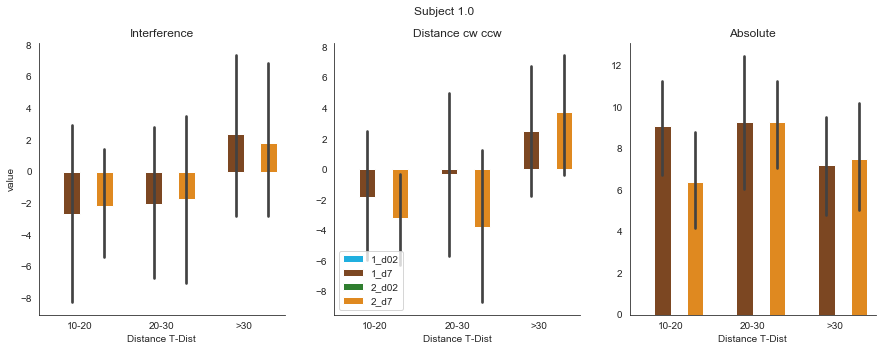

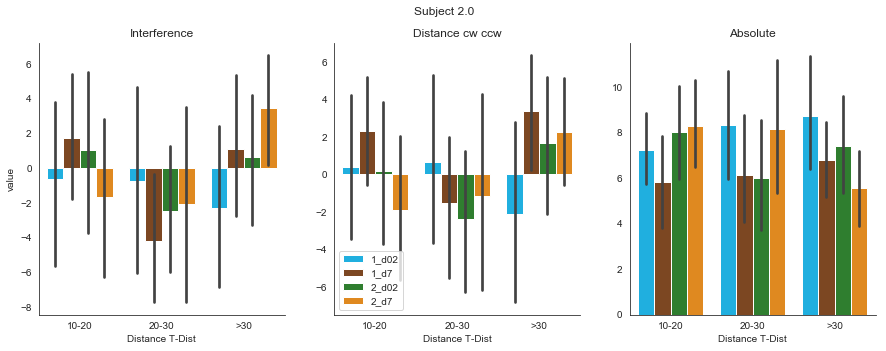

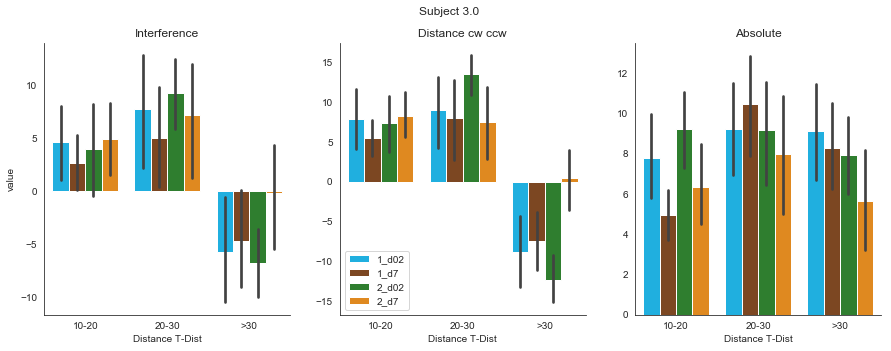

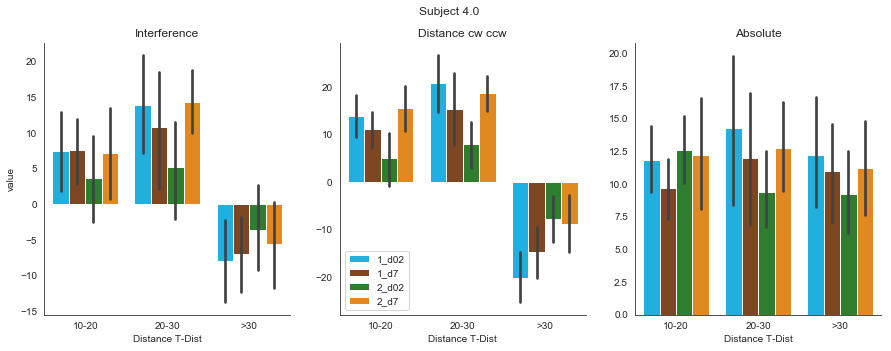

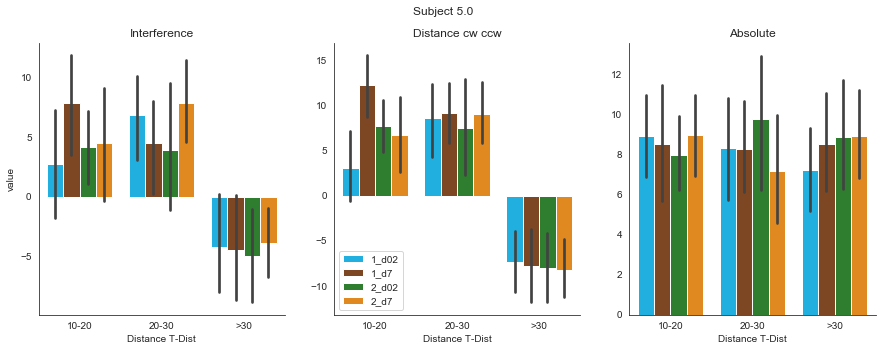

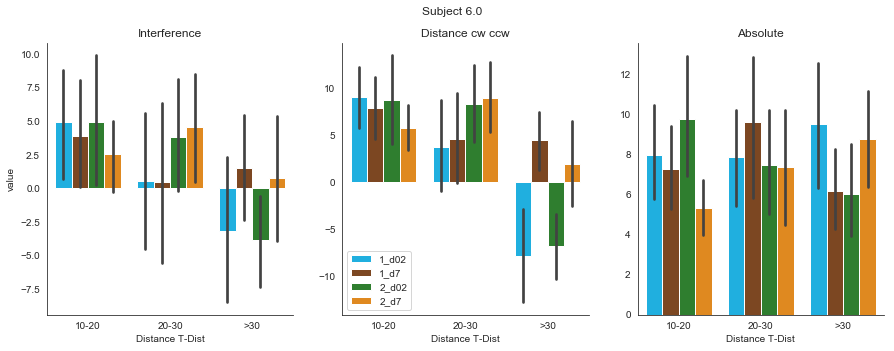

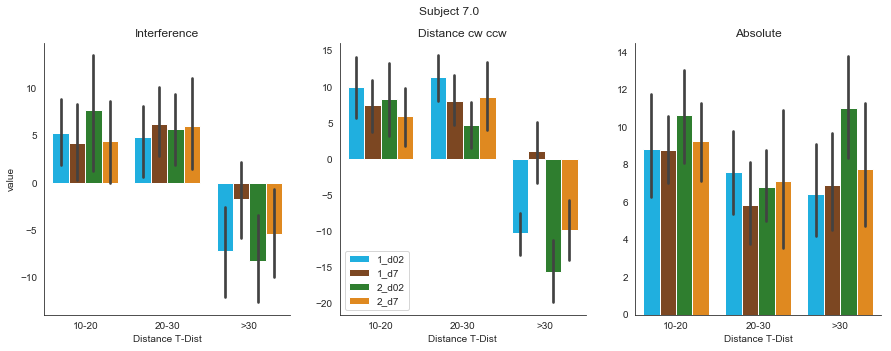

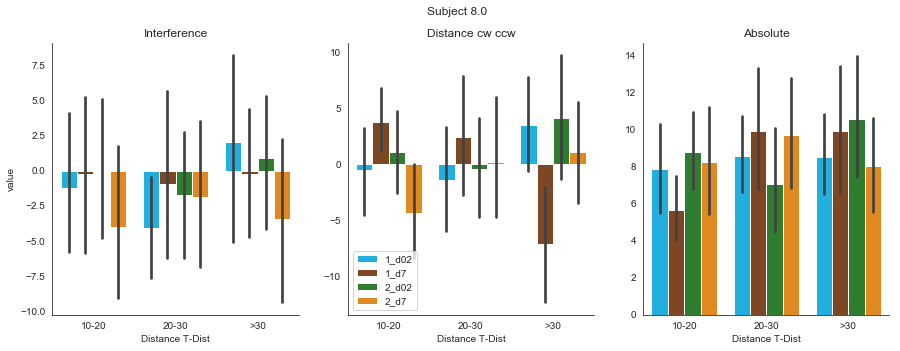

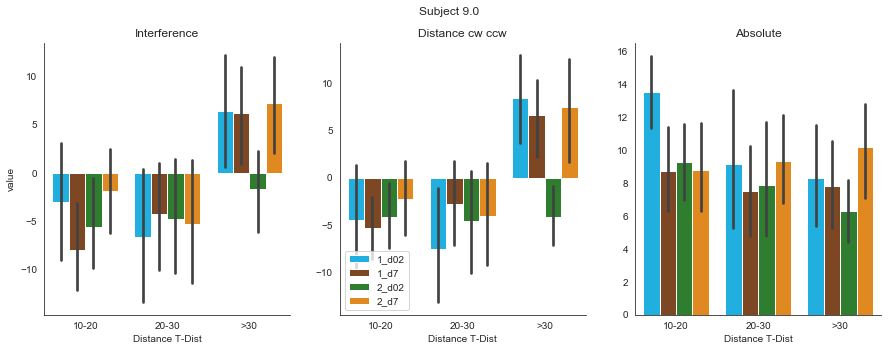

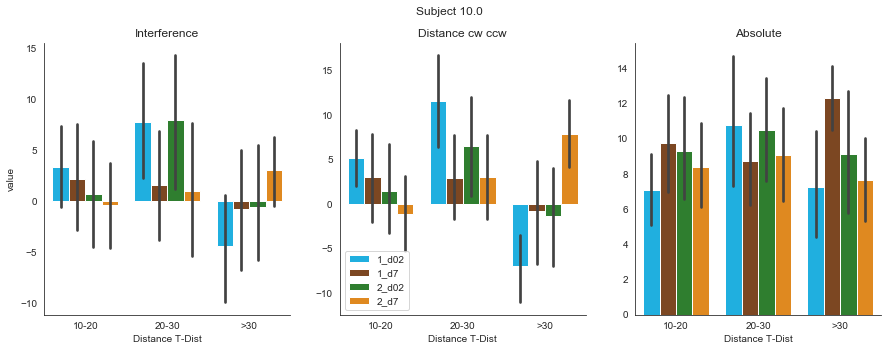

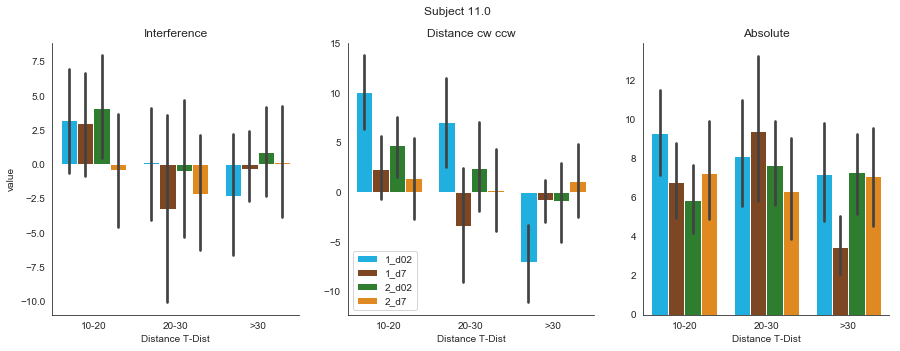

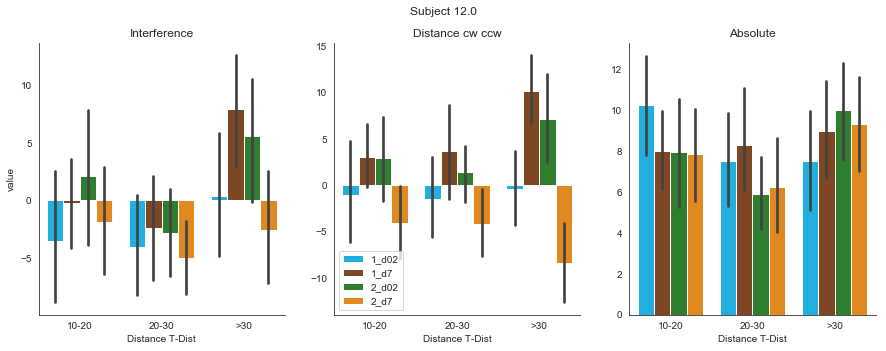

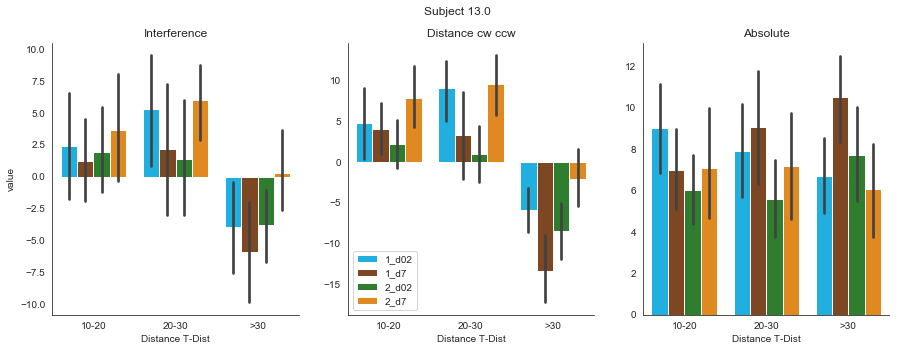

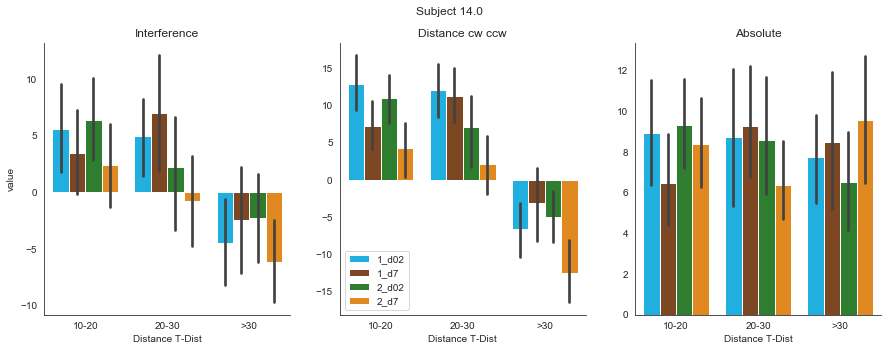

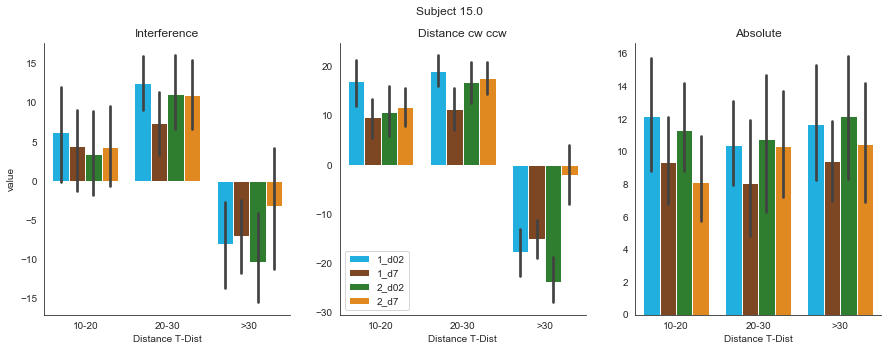

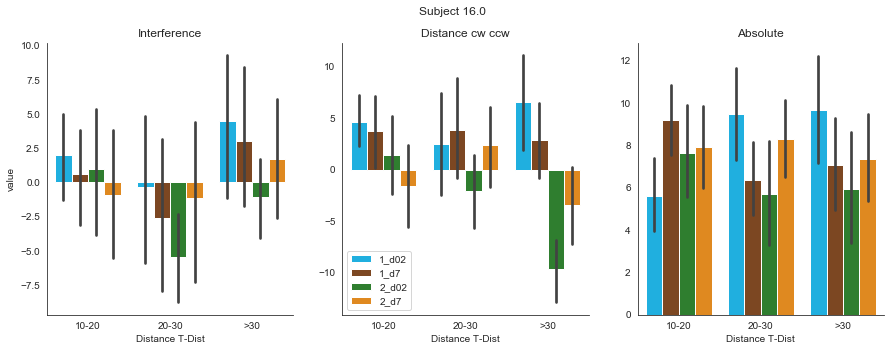

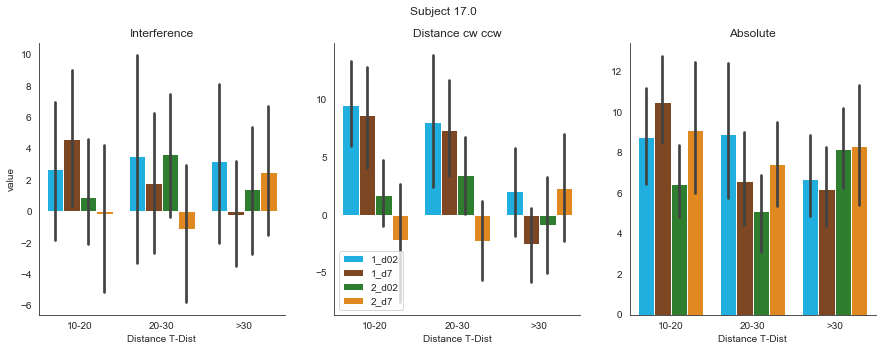

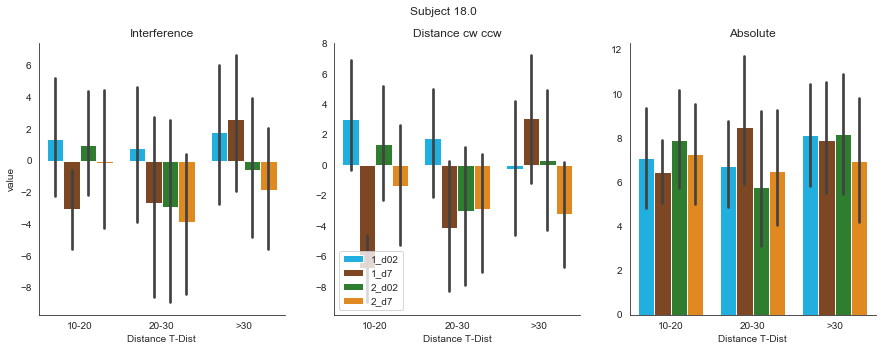

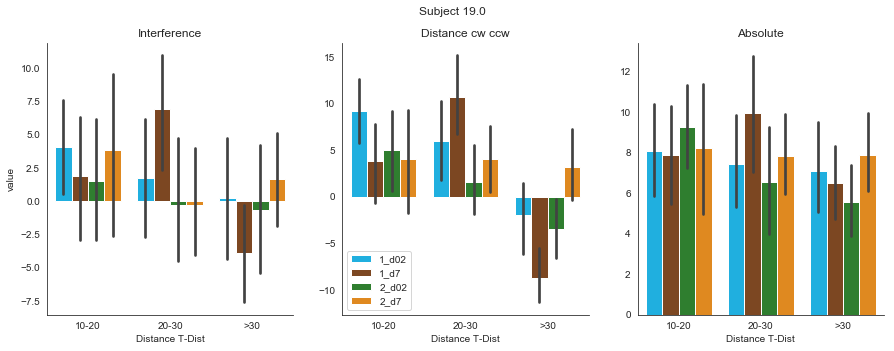

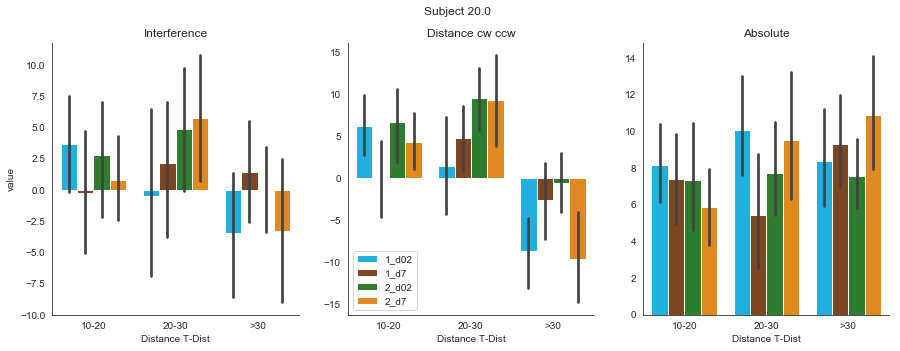

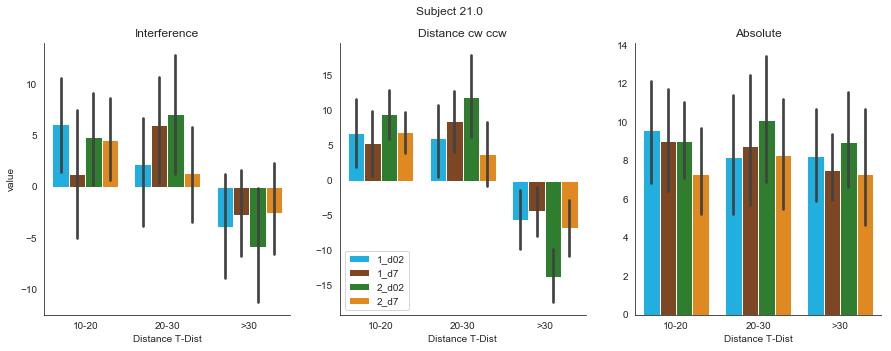

In [8]:

### SUBJECT BY SUBJECT

for SUBJ in df_analysis.subject.unique():
    df_subj = df_analysis.loc[df_analysis['subject']==SUBJ]
    #Plot of errors
    fig = plt.figure()
    fig.set_size_inches(15, 5)
    fig.tight_layout()
    fig.suptitle('Subject ' +str(SUBJ))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    sns.barplot(ax=ax1, x="type", y="Interference", hue='ord_del_cond', hue_order=['1_d02',  '1_d7', '2_d02', '2_d7'], 
                data=df_subj, palette=['deepskyblue', 'saddlebrown', 'forestgreen','darkorange'])

    sns.barplot(ax=ax2, x="type", y="distance_A_err", hue='ord_del_cond', hue_order=['1_d02',  '1_d7', '2_d02', '2_d7'],
                data=df_subj, palette=['deepskyblue', 'saddlebrown', 'forestgreen','darkorange'])

    sns.barplot( ax=ax3, x="type", y="A_err_abs", hue='ord_del_cond', hue_order=['1_d02',  '1_d7', '2_d02', '2_d7'],
                data=df_subj, palette=['deepskyblue', 'saddlebrown', 'forestgreen','darkorange'])



    axes=[ax1, ax2, ax3]
    Titles=['Interference', 'Distance cw ccw', 'Absolute']

    for i, Ax in enumerate(axes):
        Ax.spines['right'].set_visible(False)
        Ax.spines['top'].set_visible(False)
        Ax.title.set_text(Titles[i])
        Ax.legend_.remove()
        Ax.set_xticklabels(['10-20','20-30', '>30'])
        Ax.set_xlabel('Distance T-Dist')
        Ax.set_ylabel('')


    ax2.legend(loc=3)
    ax1.set_ylabel('value')
    plt.show()





C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


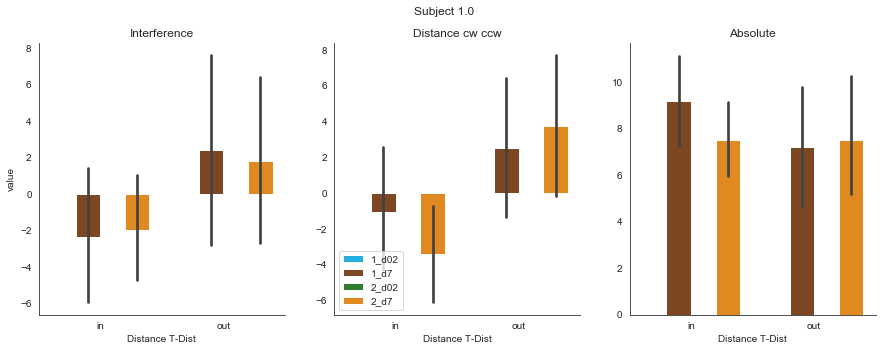

Precision 1.0 = 8.028
Interference 1.0 = -0.816
                            OLS Regression Results                            
Dep. Variable:         distance_A_err   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     2.994
Date:                Tue, 07 May 2019   Prob (F-statistic):             0.0343
Time:                        11:40:50   Log-Likelihood:                -390.71
No. Observations:                 107   AIC:                             789.4
Df Residuals:                     103   BIC:                             800.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

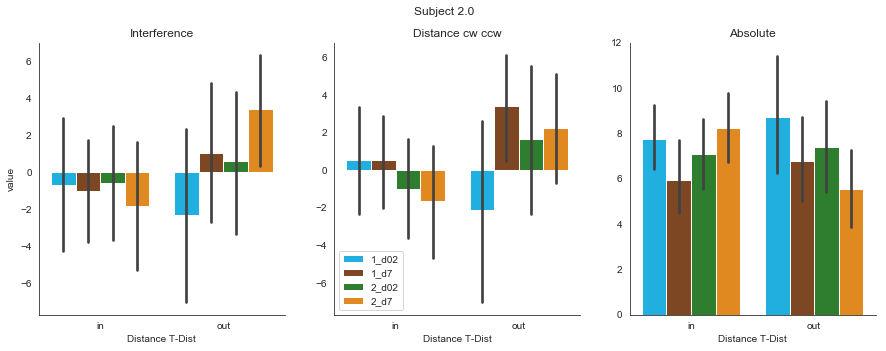

Precision 2.0 = 7.174
Interference 2.0 = -0.425
                            OLS Regression Results                            
Dep. Variable:         distance_A_err   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.176
Date:                Tue, 07 May 2019   Prob (F-statistic):              0.318
Time:                        11:40:52   Log-Likelihood:                -771.07
No. Observations:                 218   AIC:                             1558.
Df Residuals:                     210   BIC:                             1585.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

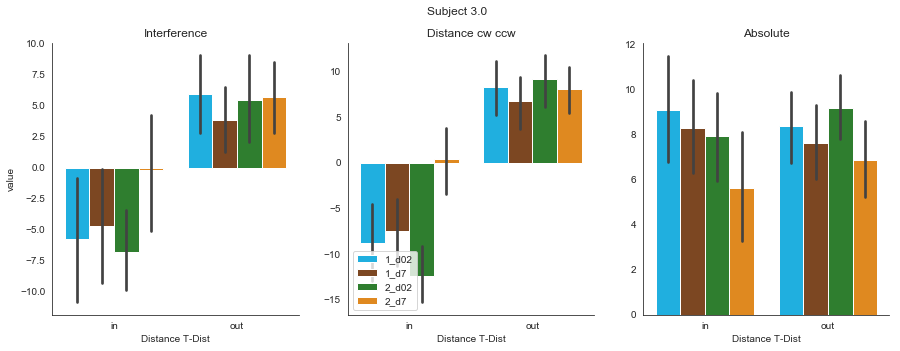

Precision 3.0 = 7.949
Interference 3.0 = 2.098
                            OLS Regression Results                            
Dep. Variable:         distance_A_err   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     25.28
Date:                Tue, 07 May 2019   Prob (F-statistic):           7.42e-25
Time:                        11:40:53   Log-Likelihood:                -766.29
No. Observations:                 217   AIC:                             1549.
Df Residuals:                     209   BIC:                             1576.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

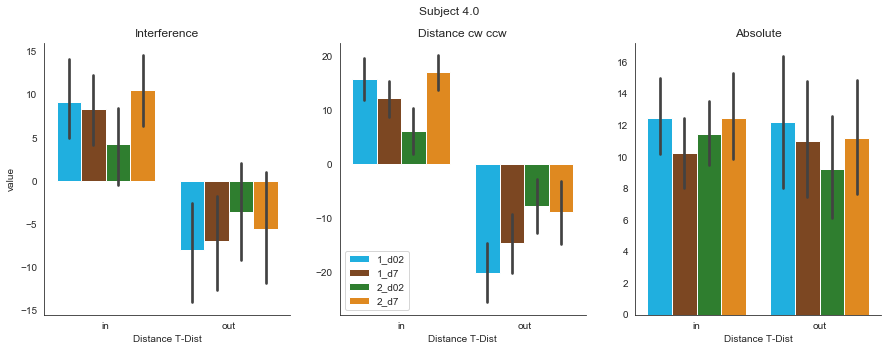

Precision 4.0 = 11.41
Interference 4.0 = 3.363
                            OLS Regression Results                            
Dep. Variable:         distance_A_err   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     38.05
Date:                Tue, 07 May 2019   Prob (F-statistic):           4.25e-34
Time:                        11:40:55   Log-Likelihood:                -836.97
No. Observations:                 217   AIC:                             1690.
Df Residuals:                     209   BIC:                             1717.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

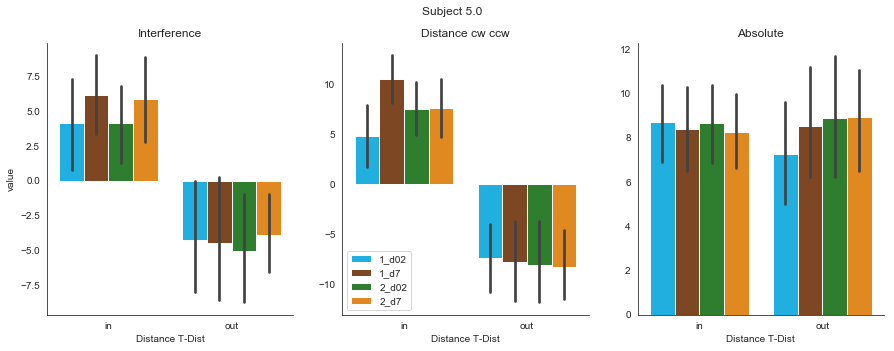

Precision 5.0 = 8.464
Interference 5.0 = 1.907
                            OLS Regression Results                            
Dep. Variable:         distance_A_err   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     24.11
Date:                Tue, 07 May 2019   Prob (F-statistic):           5.39e-24
Time:                        11:40:56   Log-Likelihood:                -780.14
No. Observations:                 220   AIC:                             1576.
Df Residuals:                     212   BIC:                             1603.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

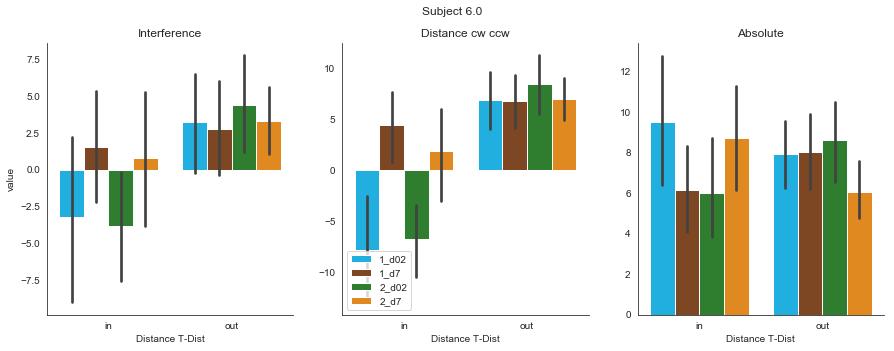

Precision 6.0 = 7.653
Interference 6.0 = 1.932
                            OLS Regression Results                            
Dep. Variable:         distance_A_err   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     11.73
Date:                Tue, 07 May 2019   Prob (F-statistic):           1.29e-12
Time:                        11:40:58   Log-Likelihood:                -794.20
No. Observations:                 222   AIC:                             1604.
Df Residuals:                     214   BIC:                             1632.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

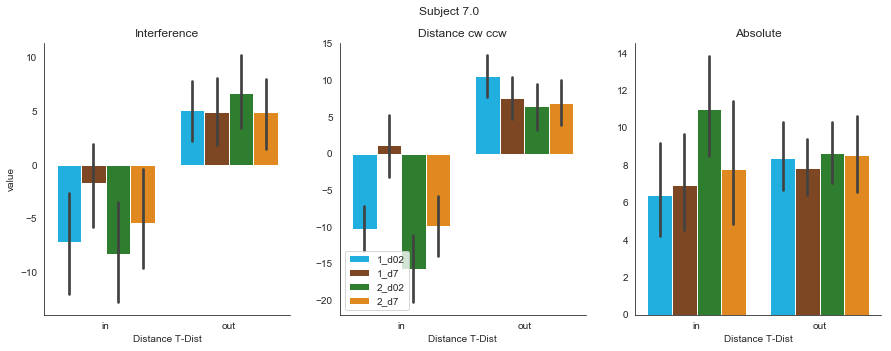

Precision 7.0 = 8.276
Interference 7.0 = 1.705
                            OLS Regression Results                            
Dep. Variable:         distance_A_err   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     28.09
Date:                Tue, 07 May 2019   Prob (F-statistic):           6.07e-27
Time:                        11:41:00   Log-Likelihood:                -771.78
No. Observations:                 214   AIC:                             1560.
Df Residuals:                     206   BIC:                             1586.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

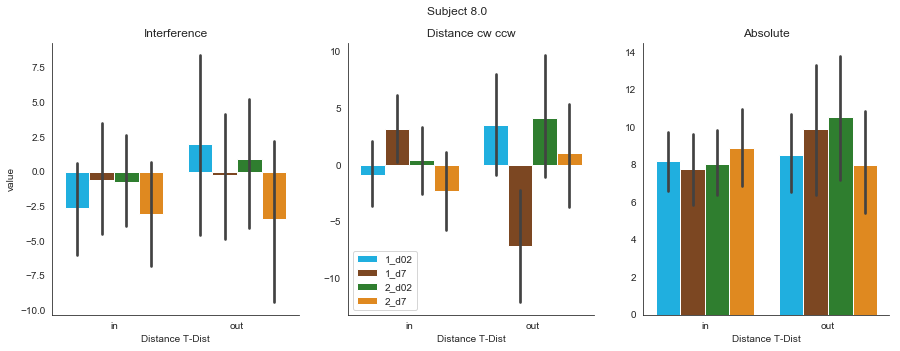

Precision 8.0 = 8.571
Interference 8.0 = -1.182
                            OLS Regression Results                            
Dep. Variable:         distance_A_err   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     2.938
Date:                Tue, 07 May 2019   Prob (F-statistic):            0.00591
Time:                        11:41:01   Log-Likelihood:                -805.08
No. Observations:                 217   AIC:                             1626.
Df Residuals:                     209   BIC:                             1653.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

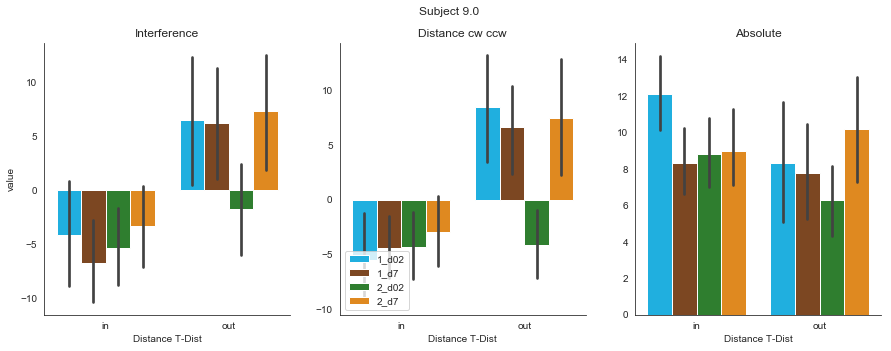

Precision 9.0 = 9.076
Interference 9.0 = -1.895
                            OLS Regression Results                            
Dep. Variable:         distance_A_err   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     7.643
Date:                Tue, 07 May 2019   Prob (F-statistic):           3.09e-08
Time:                        11:41:03   Log-Likelihood:                -833.11
No. Observations:                 223   AIC:                             1682.
Df Residuals:                     215   BIC:                             1709.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

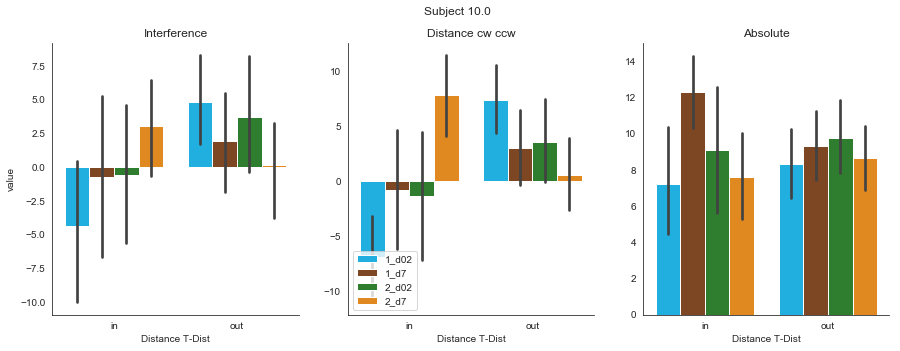

Precision 10.0 = 9.063
Interference 10.0 = 1.591
                            OLS Regression Results                            
Dep. Variable:         distance_A_err   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     4.549
Date:                Tue, 07 May 2019   Prob (F-statistic):           9.41e-05
Time:                        11:41:04   Log-Likelihood:                -832.34
No. Observations:                 221   AIC:                             1681.
Df Residuals:                     213   BIC:                             1708.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

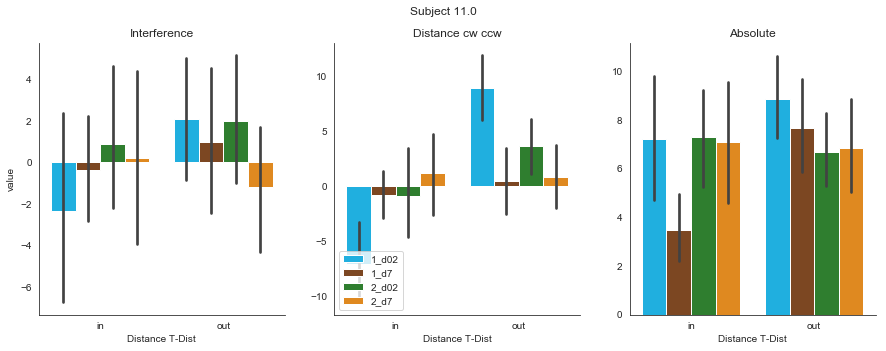

Precision 11.0 = 7.097
Interference 11.0 = 0.495
                            OLS Regression Results                            
Dep. Variable:         distance_A_err   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     7.182
Date:                Tue, 07 May 2019   Prob (F-statistic):           1.06e-07
Time:                        11:41:06   Log-Likelihood:                -771.53
No. Observations:                 217   AIC:                             1559.
Df Residuals:                     209   BIC:                             1586.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

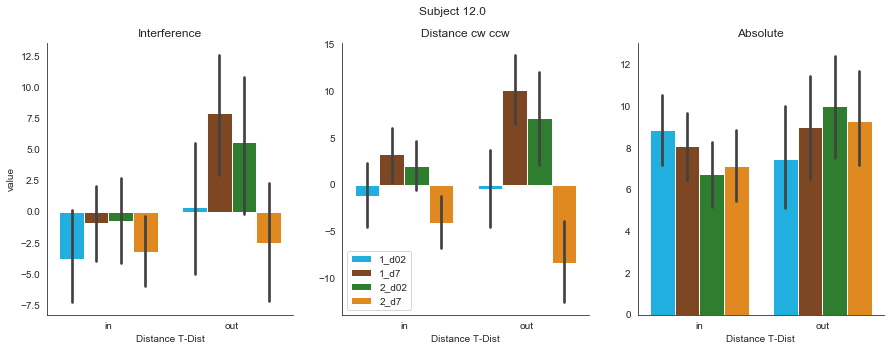

Precision 12.0 = 8.128
Interference 12.0 = -0.493
                            OLS Regression Results                            
Dep. Variable:         distance_A_err   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     8.955
Date:                Tue, 07 May 2019   Prob (F-statistic):           1.18e-09
Time:                        11:41:07   Log-Likelihood:                -795.02
No. Observations:                 219   AIC:                             1606.
Df Residuals:                     211   BIC:                             1633.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

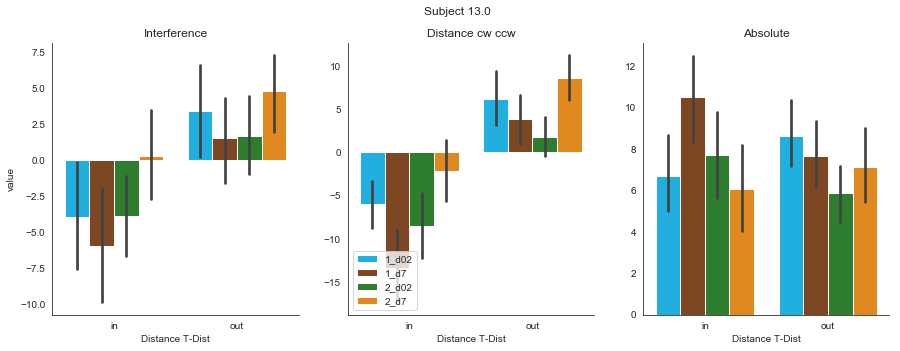

Precision 13.0 = 7.5
Interference 13.0 = 0.698
                            OLS Regression Results                            
Dep. Variable:         distance_A_err   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     21.11
Date:                Tue, 07 May 2019   Prob (F-statistic):           1.84e-21
Time:                        11:41:09   Log-Likelihood:                -775.27
No. Observations:                 220   AIC:                             1567.
Df Residuals:                     212   BIC:                             1594.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

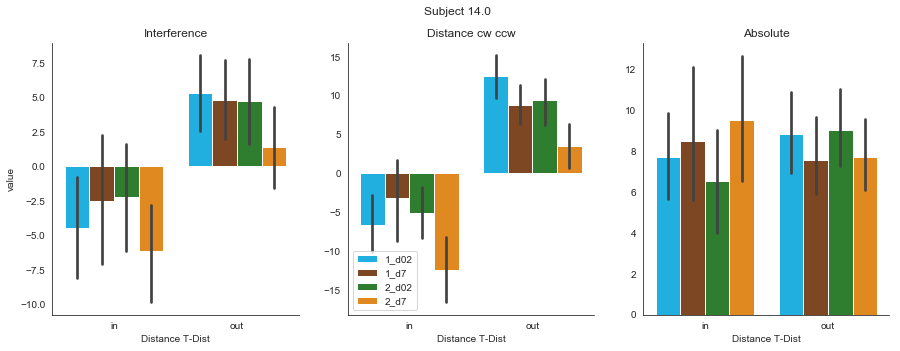

Precision 14.0 = 8.209
Interference 14.0 = 1.413
                            OLS Regression Results                            
Dep. Variable:         distance_A_err   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     25.36
Date:                Tue, 07 May 2019   Prob (F-statistic):           5.22e-25
Time:                        11:41:11   Log-Likelihood:                -786.83
No. Observations:                 220   AIC:                             1590.
Df Residuals:                     212   BIC:                             1617.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

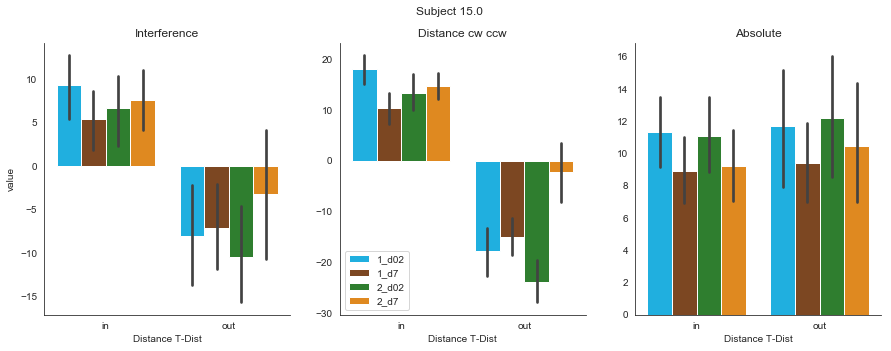

Precision 15.0 = 10.432
Interference 15.0 = 2.434
                            OLS Regression Results                            
Dep. Variable:         distance_A_err   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     68.65
Date:                Tue, 07 May 2019   Prob (F-statistic):           2.92e-51
Time:                        11:41:12   Log-Likelihood:                -823.02
No. Observations:                 222   AIC:                             1662.
Df Residuals:                     214   BIC:                             1689.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

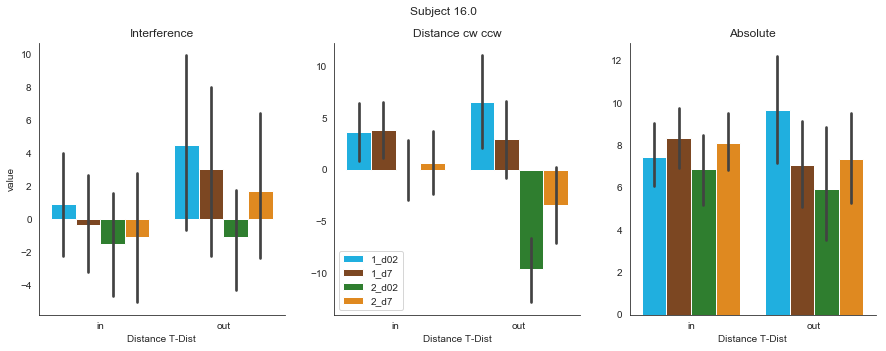

Precision 16.0 = 7.647
Interference 16.0 = 0.364
                            OLS Regression Results                            
Dep. Variable:         distance_A_err   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     6.601
Date:                Tue, 07 May 2019   Prob (F-statistic):           4.56e-07
Time:                        11:41:14   Log-Likelihood:                -788.67
No. Observations:                 221   AIC:                             1593.
Df Residuals:                     213   BIC:                             1621.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

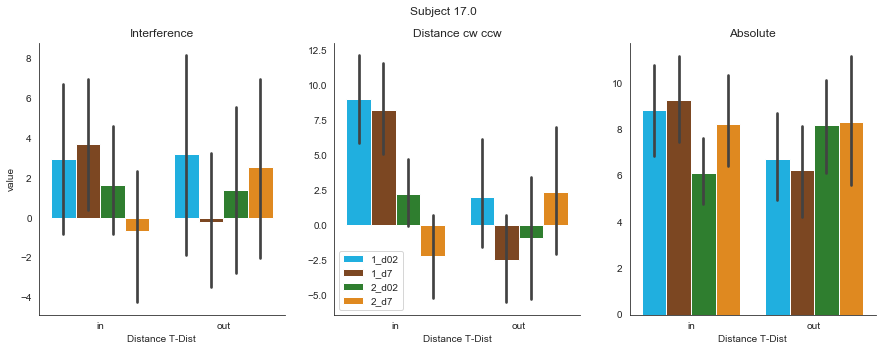

Precision 17.0 = 7.845
Interference 17.0 = 1.82
                            OLS Regression Results                            
Dep. Variable:         distance_A_err   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     7.401
Date:                Tue, 07 May 2019   Prob (F-statistic):           5.93e-08
Time:                        11:41:15   Log-Likelihood:                -790.22
No. Observations:                 219   AIC:                             1596.
Df Residuals:                     211   BIC:                             1624.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

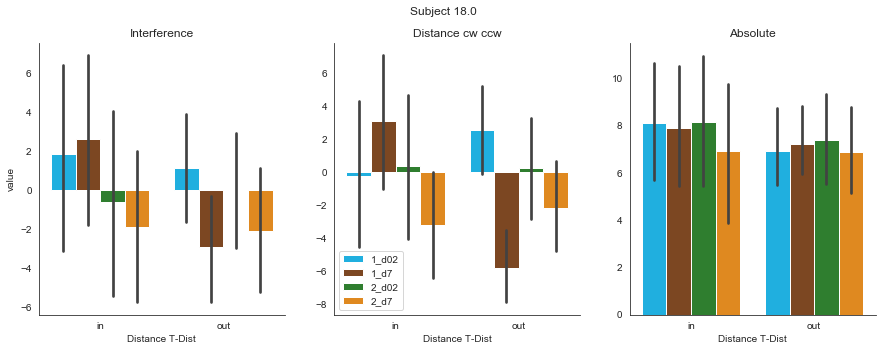

Precision 18.0 = 7.323
Interference 18.0 = -0.484
                            OLS Regression Results                            
Dep. Variable:         distance_A_err   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     3.645
Date:                Tue, 07 May 2019   Prob (F-statistic):           0.000980
Time:                        11:41:17   Log-Likelihood:                -784.41
No. Observations:                 220   AIC:                             1585.
Df Residuals:                     212   BIC:                             1612.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

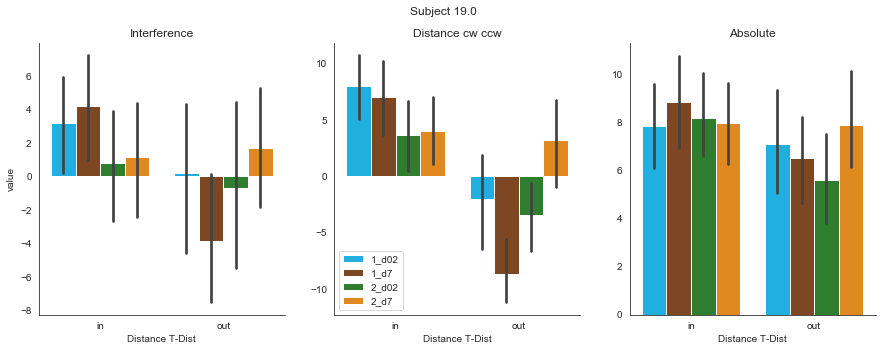

Precision 19.0 = 7.759
Interference 19.0 = 1.352
                            OLS Regression Results                            
Dep. Variable:         distance_A_err   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     9.553
Date:                Tue, 07 May 2019   Prob (F-statistic):           2.63e-10
Time:                        11:41:18   Log-Likelihood:                -788.74
No. Observations:                 220   AIC:                             1593.
Df Residuals:                     212   BIC:                             1621.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

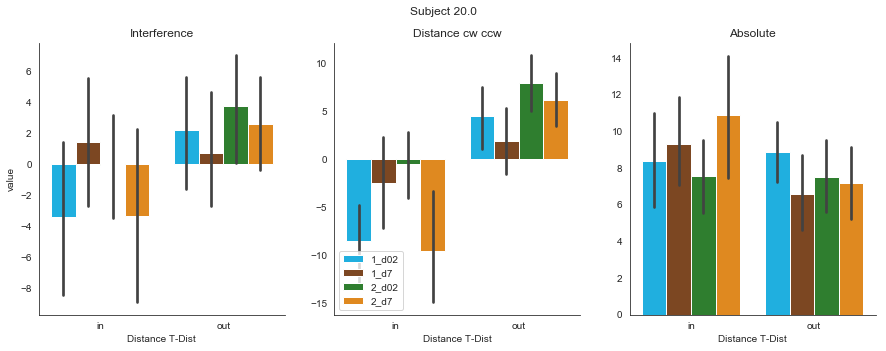

Precision 20.0 = 8.182
Interference 20.0 = 0.979
                            OLS Regression Results                            
Dep. Variable:         distance_A_err   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     11.35
Date:                Tue, 07 May 2019   Prob (F-statistic):           4.73e-12
Time:                        11:41:20   Log-Likelihood:                -740.01
No. Observations:                 203   AIC:                             1496.
Df Residuals:                     195   BIC:                             1523.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

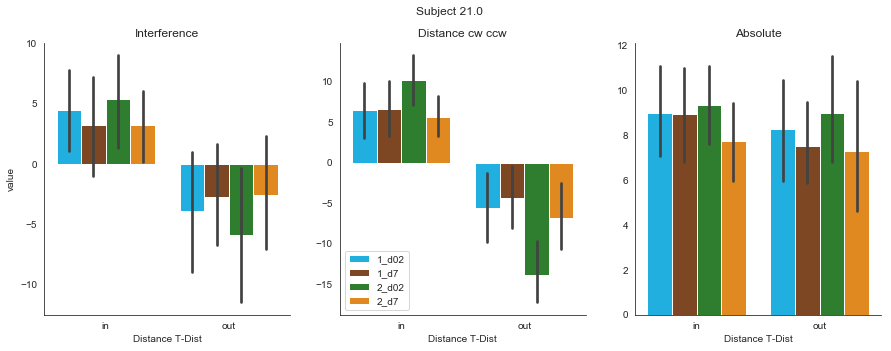

Precision 21.0 = 8.482
Interference 21.0 = 1.373
                            OLS Regression Results                            
Dep. Variable:         distance_A_err   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     20.12
Date:                Tue, 07 May 2019   Prob (F-statistic):           1.47e-20
Time:                        11:41:21   Log-Likelihood:                -792.74
No. Observations:                 218   AIC:                             1601.
Df Residuals:                     210   BIC:                             1629.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [9]:
### SUBJECT BY SUBJECT

for SUBJ in df_analysis.subject.unique():
    df_subj = df_analysis.loc[df_analysis['subject']==SUBJ]
    #Plot of errors
    fig = plt.figure()
    fig.set_size_inches(15, 5)
    fig.tight_layout()
    fig.suptitle('Subject ' +str(SUBJ))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    sns.barplot(ax=ax1, x="dist_in_out", y="Interference", hue='ord_del_cond', hue_order=['1_d02',  '1_d7', '2_d02', '2_d7'], 
                data=df_subj, palette=['deepskyblue', 'saddlebrown', 'forestgreen','darkorange'])

    sns.barplot(ax=ax2, x="dist_in_out", y="distance_A_err", hue='ord_del_cond', hue_order=['1_d02',  '1_d7', '2_d02', '2_d7'],
                data=df_subj, palette=['deepskyblue', 'saddlebrown', 'forestgreen','darkorange'])

    sns.barplot( ax=ax3, x="dist_in_out", y="A_err_abs", hue='ord_del_cond', hue_order=['1_d02',  '1_d7', '2_d02', '2_d7'],
                data=df_subj, palette=['deepskyblue', 'saddlebrown', 'forestgreen','darkorange'])



    axes=[ax1, ax2, ax3]
    Titles=['Interference', 'Distance cw ccw', 'Absolute']

    for i, Ax in enumerate(axes):
        Ax.spines['right'].set_visible(False)
        Ax.spines['top'].set_visible(False)
        Ax.title.set_text(Titles[i])
        Ax.legend_.remove()
        Ax.set_xticklabels(['in','out'])
        Ax.set_xlabel('Distance T-Dist')
        Ax.set_ylabel('')


    ax2.legend(loc=3)
    ax1.set_ylabel('value')
    plt.show()
    
    Precision = round(df_subj.A_err_abs.mean(), 3)
    Interference = round(df_subj.Interference.mean(), 3)
    print( 'Precision ' + str(SUBJ) +  ' = ' + str(Precision))
    print( 'Interference ' + str(SUBJ) +  ' = ' + str(Interference))
    result = smf.ols(formula="distance_A_err ~ delay*order*dist_in_out ", data=df_subj).fit()
    print(result.summary())



Summary of all together.  

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimizat

                   Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      distance_A_err
No. Observations:      4475         Method:                  REML          
No. Groups:            21           Scale:                   113.9282      
Min. group size:       107          Likelihood:              -17001.5792   
Max. group size:       223          Converged:               No            
Mean group size:       213.1                                               
---------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        8.212    2.504  3.279 0.001   3.304 13.119
dist_in_out[T.out]             -13.011    1.589 -8.190 0.000 -16.125 -9.897
delay                           -0.375    0.182 -2.058 0.040  -0.732 -0.018
delay:dist_in_out[T.out]       

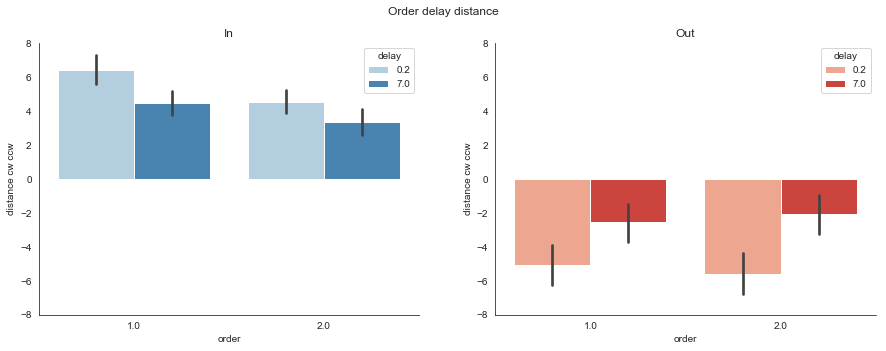

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likel

                 Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    distance_A_err
No. Observations:      4475       Method:                REML          
No. Groups:            21         Scale:                 113.9030      
Min. group size:       107        Likelihood:            -17000.8918   
Max. group size:       223        Converged:             No            
Mean group size:       213.1                                           
-----------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------
Intercept                  8.256    2.476   3.335 0.001   3.403  13.109
dist_in_out[T.out]       -13.145    1.134 -11.589 0.000 -15.368 -10.922
delay                     -0.387    0.152  -2.539 0.011  -0.686  -0.088
delay:dist_in_out[T.out]   0.677    0.100   6.798 0.000   0.482   0.872
order    

In [10]:
fig = plt.figure()
fig.set_size_inches(15, 5)
fig.tight_layout()
fig.suptitle('Order delay distance')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.barplot( ax= ax1, x="order", y="distance_A_err", hue='delay', data=df_analysis.loc[df_analysis['dist_in_out']=='in'], palette='Blues')
sns.barplot( ax= ax2, x="order", y="distance_A_err", hue='delay', data=df_analysis.loc[df_analysis['dist_in_out']=='out'], palette='Reds')
axes=[ax1, ax2]
Titles=['In', 'Out']

for i, Ax in enumerate(axes):
    Ax.spines['right'].set_visible(False)
    Ax.spines['top'].set_visible(False)
    Ax.title.set_text(Titles[i])
    #Ax.legend_.remove()
    #Ax.set_xticklabels(['in','out'])
    #Ax.set_xlabel('Distance T-Dist')
    Ax.set_ylabel('distance cw ccw')
    Ax.set_ylim(-8,8)

    
    
result = smf.mixedlm(formula="distance_A_err ~ delay*order*dist_in_out ", data=df_analysis, groups='subject').fit()
print(result.summary())

plt.show()


result = smf.mixedlm(formula="distance_A_err ~ delay*order + delay*dist_in_out + order*dist_in_out ", data=df_analysis, groups='subject').fit()
print(result.summary())


# result = smf.mixedlm(formula="distance_A_err ~ delay*order ", data=df_analysis.loc[ df_analysis['dist_in_out']=='in'], groups='subject').fit()
# print(result.summary())


# result = smf.mixedlm(formula="distance_A_err ~ delay*order ", data=df_analysis.loc[df_analysis['dist_in_out']=='out'], groups='subject').fit()
# print(result.summary())


result = smf.mixedlm(formula="distance_A_err ~ delay + order ", data=df_analysis.loc[ df_analysis['dist_in_out']=='in'], groups='subject').fit()
print(result.summary())


result = smf.mixedlm(formula="distance_A_err ~ delay + order ", data=df_analysis.loc[df_analysis['dist_in_out']=='out'], groups='subject').fit()
print(result.summary())




C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


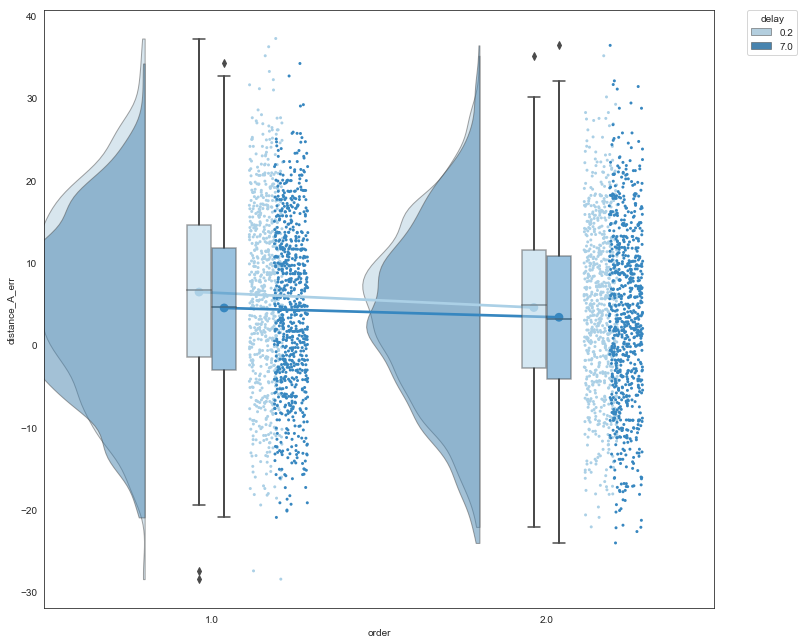

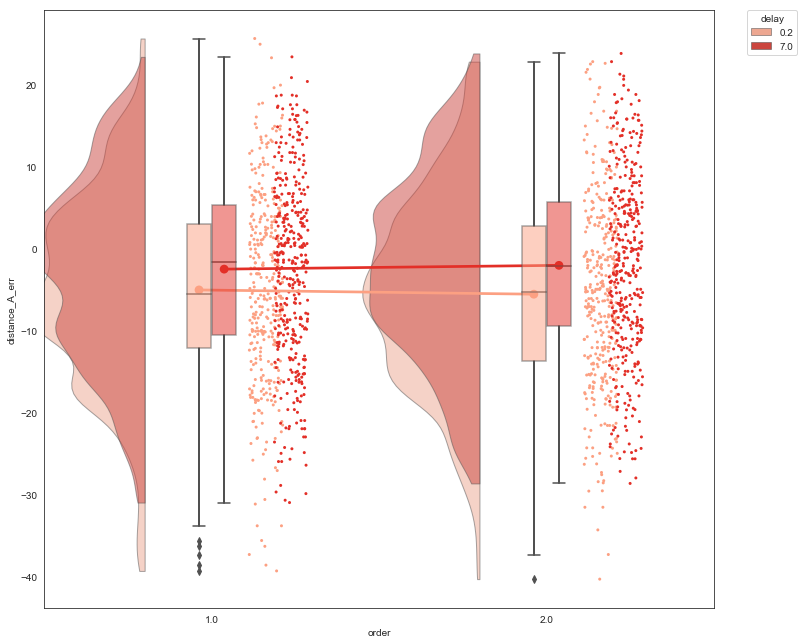

In [68]:


pt.RainCloud(x = dx, y = dy, hue=dhue, data=df_analysis.loc[df_analysis['dist_in_out']=='in'],  palette = 'Blues', bw = sigma, width_viol = .7, 
                orient =ort , alpha = .5, dodge = True, pointplot = True, move = .2)

pt.RainCloud(x = dx, y = dy, hue=dhue, data=df_analysis.loc[df_analysis['dist_in_out']=='out'],  palette = 'Reds', bw = sigma, width_viol = .7, 
                orient =ort , alpha = .5, dodge = True, pointplot = True, move = .2)

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


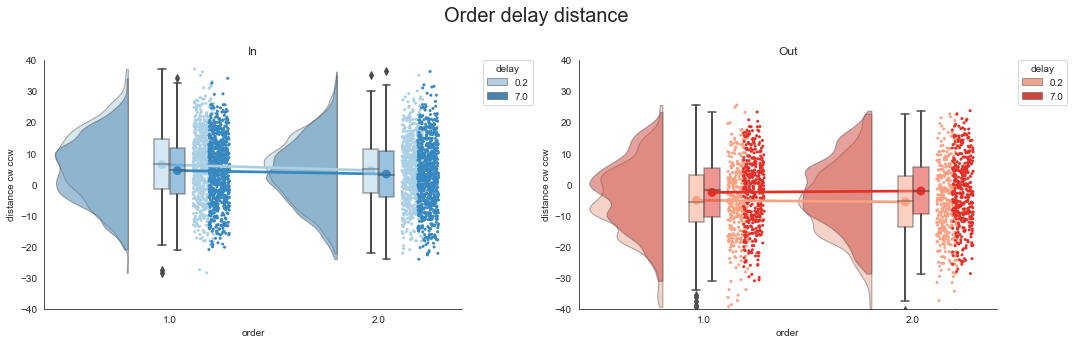

In [103]:
fig = plt.figure()
fig.set_size_inches(15, 5)
fig.suptitle('Order delay distance', size=20)

dx="order"; dy="distance_A_err"; dhue="delay"; sigma=.2; ort="o"

ax1=plt.subplot(121)
pt.RainCloud(ax=ax1, x = dx, y = dy, hue=dhue, data=df_analysis.loc[df_analysis['dist_in_out']=='in'],  palette = 'Blues', bw = sigma, width_viol = .7, 
                orient =ort , alpha = .5, dodge = True, pointplot = True, move = .2)

ax2=plt.subplot(122)

pt.RainCloud(ax=ax2, x = dx, y = dy, hue=dhue, data=df_analysis.loc[df_analysis['dist_in_out']=='out'],  palette = 'Reds', bw = sigma, width_viol = .7, 
                orient =ort , alpha = .5, dodge = True, pointplot = True, move = .2)

axes=[ax1, ax2]
Titles=['In', 'Out']

for i, Ax in enumerate(axes):
    Ax.spines['right'].set_visible(False)
    Ax.spines['top'].set_visible(False)
    Ax.title.set_text(Titles[i])
    Ax.set_ylabel('distance cw ccw')
    Ax.set_xlim(-0.6, 1.4)
    Ax.set_ylim(-40, 40)

fig.tight_layout(rect=[0, 0.03, 1, 0.90])


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-0.6, 1.4)

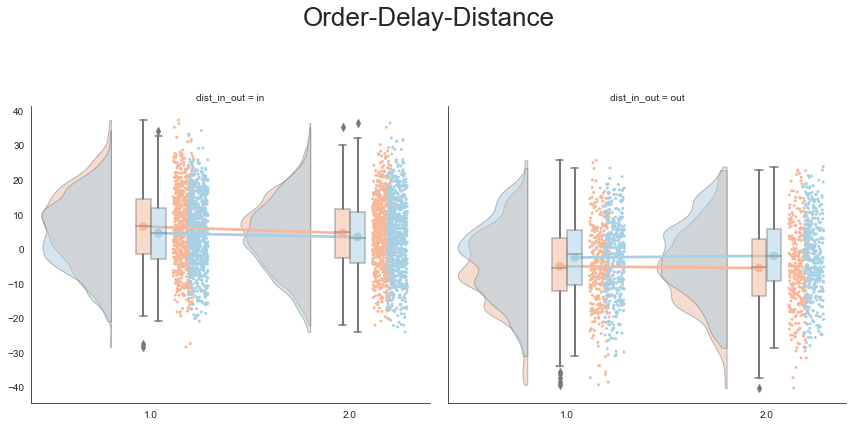

In [38]:

g = sns.FacetGrid(df_analysis, col = "dist_in_out", height = 6)

dx="order"; dy="distance_A_err"; dhue="delay"; sigma=.2; pal='RdBu'; ort="o"

g = g.map_dataframe(pt.RainCloud, x = dx, y = dy, hue=dhue, hue_order=[0.2,7], data = df_analysis,  palette = pal, bw = sigma, width_viol = .7,
                figsize = (12,5), orient =ort , alpha = .5, dodge = True, pointplot = True, move = .2, ax = g.axes)

g.fig.subplots_adjust(top=0.75)
g.fig.suptitle("Order-Delay-Distance",  fontsize=26)

# ax=pt.RainCloud(x = dx, y = dy, hue=dhue, data = df_analysis,  palette = pal, bw = sigma, width_viol = .7,
#                 figsize = (12,5), orient =ort , alpha = .5, dodge = True, pointplot = True, move = .2)

#plt.title('Delay effect by distance', size=15)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().get_xaxis().tick_bottom()
# plt.gca().get_yaxis().tick_left()
# plt.ylabel('distance cw ccw' )
# plt.xlabel('delay')
plt.xlim(-0.6, 1.4)
# plt.show()


In [ ]:
g = sns.FacetGrid(df, col = "gr2", height = 6)
g = g.map_dataframe(pt.RainCloud, x = "group", y = "score", data = df,
                    orient = "h", ax = g.axes)

Conditions comparison.  

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


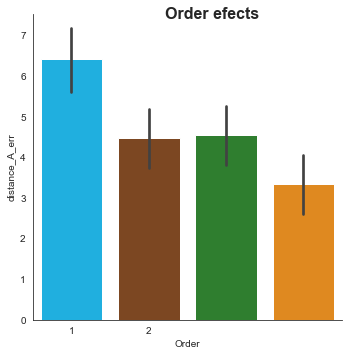

             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  distance_A_err
No. Observations:   2981     Method:              REML          
No. Groups:         21       Scale:               89.9585       
Min. group size:    73       Likelihood:          -10970.2553   
Max. group size:    152      Converged:           Yes           
Mean group size:    142.0                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              6.075    1.080  5.623 0.000  3.957  8.192
ord_del_cond[T.1_d7]  -1.575    0.495 -3.180 0.001 -2.547 -0.604
ord_del_cond[T.2_d02] -1.802    0.501 -3.598 0.000 -2.783 -0.820
ord_del_cond[T.2_d7]  -2.665    0.495 -5.388 0.000 -3.634 -1.695
subject Var           21.818    0.752                           



In [11]:

order_cat = ['1_d02',  '1_d7', '2_d02', '2_d7']
df_analysis['ord_del_cond'] = pd.Categorical(df_analysis['ord_del_cond'], order_cat)

g = sns.factorplot(x="ord_del_cond", y="distance_A_err", data=df_analysis.loc[df_analysis['dist_in_out']=='in'],
                   kind='bar', palette=['deepskyblue', 'saddlebrown', 'forestgreen','darkorange'])
sns.set_style('white')
g.set_axis_labels("Order", "distance_A_err")
g.set_xticklabels(['1','2'])
g.fig.suptitle('Order efects', fontsize=16, x=0.6, weight='demibold')
plt.show()

result = smf.mixedlm(formula="distance_A_err ~ ord_del_cond", data=df_analysis.loc[df_analysis['dist_in_out']=='in'], groups='subject').fit()
print(result.summary())  

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update yo

             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  distance_A_err
No. Observations:   2981     Method:              REML          
No. Groups:         21       Scale:               89.9585       
Min. group size:    73       Likelihood:          -10970.2553   
Max. group size:    152      Converged:           Yes           
Mean group size:    142.0                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              6.075    1.080  5.623 0.000  3.957  8.192
ord_del_cond[T.1_d7]  -1.575    0.495 -3.180 0.001 -2.547 -0.604
ord_del_cond[T.2_d02] -1.802    0.501 -3.598 0.000 -2.783 -0.820
ord_del_cond[T.2_d7]  -2.665    0.495 -5.388 0.000 -3.634 -1.695
subject Var           21.818    0.752                           

             Mixed Linear Model Regres

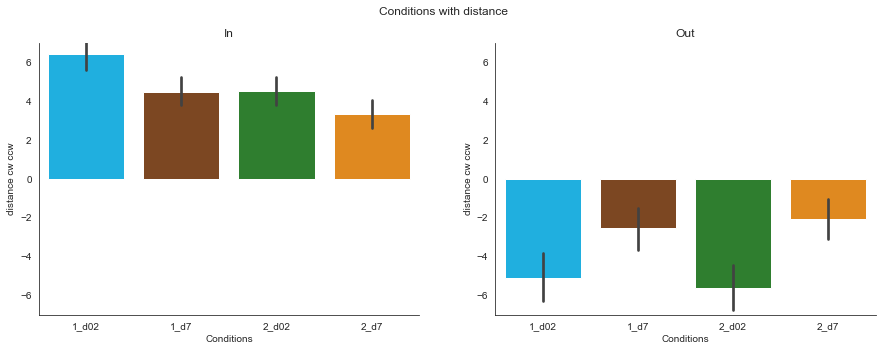

In [12]:
fig = plt.figure()
fig.set_size_inches(15, 5)
fig.tight_layout()
fig.suptitle('Conditions with distance')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

g = sns.factorplot(ax= ax1, x="ord_del_cond", y="distance_A_err", data=df_analysis.loc[df_analysis['dist_in_out']=='in'],
                   kind='bar', palette=['deepskyblue', 'saddlebrown', 'forestgreen','darkorange'])


h= sns.factorplot(ax= ax2, x="ord_del_cond", y="distance_A_err", data=df_analysis.loc[df_analysis['dist_in_out']=='out'],
                   kind='bar', palette=['deepskyblue', 'saddlebrown', 'forestgreen','darkorange'])

plt.close()
plt.close()

axes=[ax1, ax2]
Titles=['In', 'Out']

for i, Ax in enumerate(axes):
    Ax.spines['right'].set_visible(False)
    Ax.spines['top'].set_visible(False)
    Ax.title.set_text(Titles[i])
    #Ax.legend_.remove()
    #Ax.set_xticklabels(['in','out'])
    Ax.set_xlabel('Conditions')
    Ax.set_ylabel('distance cw ccw')
    Ax.set_ylim(-7,7)


    
result = smf.mixedlm(formula="distance_A_err ~ ord_del_cond", data=df_analysis.loc[df_analysis['dist_in_out']=='in'], groups='subject').fit()
print(result.summary())  
    
result = smf.mixedlm(formula="distance_A_err ~ ord_del_cond", data=df_analysis.loc[df_analysis['dist_in_out']=='out'], groups='subject').fit()
print(result.summary())  

Main effects plots.  
+ **Distance**
+ **Order**
+ **Delay**


Using most combinent measure (cw-ccw distance or absolute error).

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


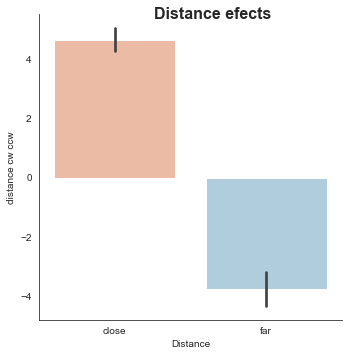

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likel

             Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  distance_A_err
No. Observations:  4475     Method:              REML          
No. Groups:        21       Scale:               115.3566      
Min. group size:   107      Likelihood:          -17027.0956   
Max. group size:   223      Converged:           No            
Mean group size:   213.1                                       
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            4.610    2.352   1.960 0.050 -0.000  9.220
dist_in_out[T.out]  -8.453    0.341 -24.819 0.000 -9.121 -7.786
subject Var        115.357                                     



C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


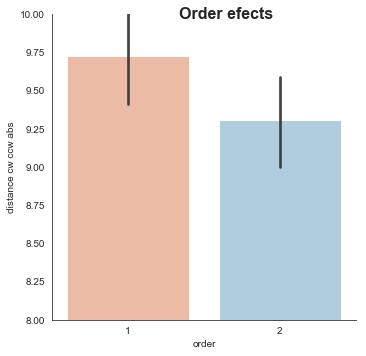

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likel

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_A_err_abs
No. Observations: 4475    Method:             REML              
No. Groups:       21      Scale:              42.1040           
Min. group size:  107     Likelihood:         -14751.6086       
Max. group size:  223     Converged:          No                
Mean group size:  213.1                                         
------------------------------------------------------------------
              Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept     10.073      0.567   17.758   0.000    8.961   11.185
order         -0.396      0.194   -2.038   0.042   -0.776   -0.015
subject Var    4.770      0.240                                   



C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


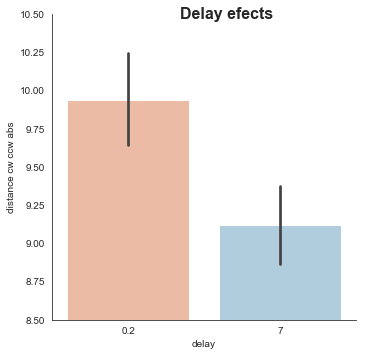

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: distance_A_err_abs
No. Observations: 4475    Method:             REML              
No. Groups:       21      Scale:              42.0201           
Min. group size:  107     Likelihood:         -14749.1556       
Max. group size:  223     Converged:          No                
Mean group size:  213.1                                         
------------------------------------------------------------------
              Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept      9.872      0.501   19.715   0.000    8.890   10.853
delay         -0.104      0.029   -3.590   0.000   -0.160   -0.047
subject Var    4.812      0.248                                   



C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2026: ConvergenceWarning: Gradient optimization failed.
  warnings.warn(msg, ConvergenceWarning)


In [13]:
#Plots summary

#### Distance
g = sns.factorplot(x="dist_in_out", y="distance_A_err", data=df_analysis,
                   kind='bar', palette='RdBu')

sns.set_style('white')
g.set_axis_labels("Distance", "distance cw ccw")
g.set_xticklabels(['close','far'])
g.fig.suptitle('Distance efects', fontsize=16, x=0.6, weight='demibold')

plt.show()

result = smf.mixedlm(formula="distance_A_err ~ dist_in_out", data=df_analysis, groups='subject').fit()
print(result.summary())




df_analysis['distance_A_err_abs'] = df_analysis['distance_A_err'].copy()
df_analysis['distance_A_err_abs'] = abs(df_analysis['distance_A_err_abs'])



#### Order
g = sns.factorplot(x="order", y="distance_A_err_abs", data=df_analysis,
                   kind='bar', palette='RdBu')

sns.set_style('white')
g.set_axis_labels("order", "distance cw ccw abs")
g.set_xticklabels(['1','2'])
plt.ylim(8,10)
g.fig.suptitle('Order efects', fontsize=16, x=0.6, weight='demibold')

plt.show()

result = smf.mixedlm(formula="distance_A_err_abs ~ order", data=df_analysis, groups='subject').fit()
print(result.summary())



####  Delay
g = sns.factorplot(x="delay", y="distance_A_err_abs", data=df_analysis,
                   kind='bar', palette='RdBu')

sns.set_style('white')
g.set_axis_labels("delay", "distance cw ccw abs")
g.set_xticklabels(['0.2','7'])
plt.ylim(8.5,10.5)
g.fig.suptitle('Delay efects', fontsize=16, x=0.6, weight='demibold')

plt.show()

result = smf.mixedlm(formula="distance_A_err_abs ~ delay", data=df_analysis, groups='subject').fit()
print(result.summary())




In [18]:
df_analysis.columns


Index(['A_err', 'Interference', 'A_R', 'A_err_abs', 'delay', 'distance',
       'subject', 'order', 'cond', 'type', 'A_dist', 'A_T',
       'A_err_int_theoretical', 'A_res', 'A_err_theoretical', 'cw_ccw',
       'Interference_col', 'sex', 'dist_in_out', 'ord_del_cond',
       'distance_A_err', 'distance_A_err_abs'],
      dtype='object')

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


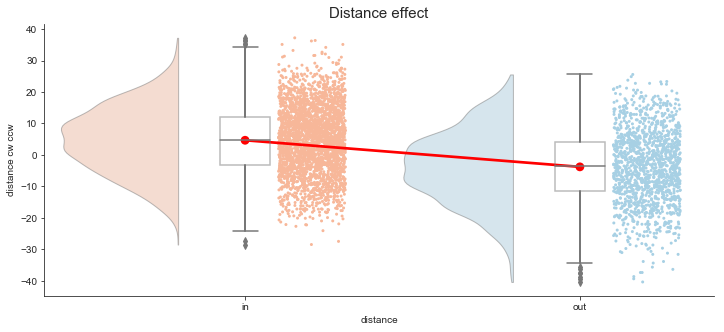

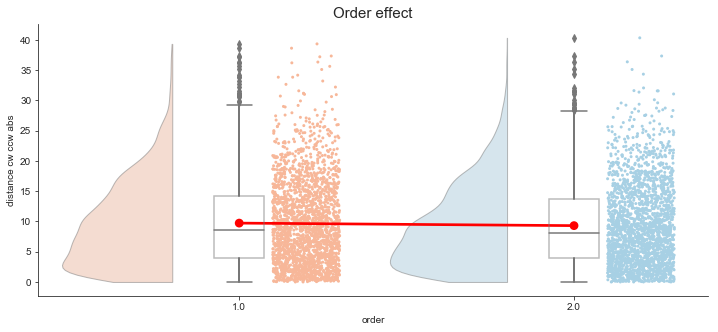

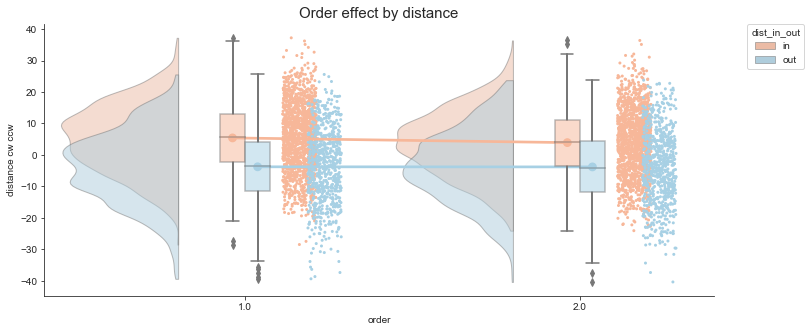

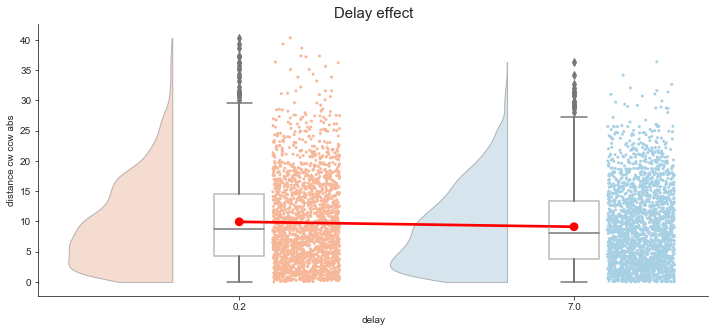

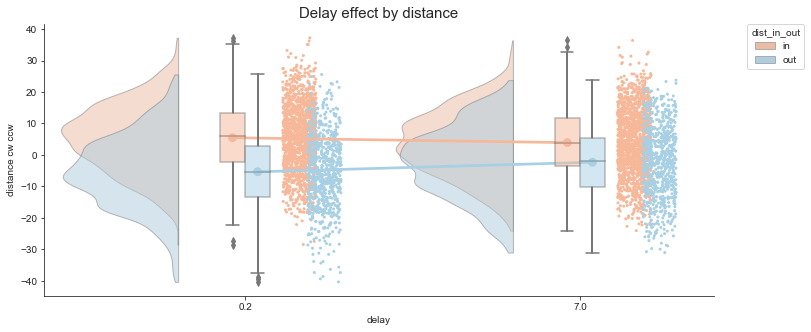

In [28]:
dx="dist_in_out"; dy="distance_A_err"; sigma=.2; pal='RdBu'; ort="o"
ax=pt.RainCloud(x = dx, y = dy, data = df_analysis,  palette = pal, bw = sigma, width_viol = .7,
                figsize = (12,5), orient =ort , alpha = .5, dodge = True, pointplot = True, move = .2)

plt.title('Distance effect', size=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.ylabel('distance cw ccw')
plt.xlabel('distance')
plt.xlim(-0.6, 1.4)
plt.show()



dx="order"; dy="distance_A_err_abs"; sigma=.2; pal='RdBu'; ort="o"
ax=pt.RainCloud(x = dx, y = dy, data = df_analysis,  palette = pal, bw = sigma, width_viol = .7,
                figsize = (12,5), orient =ort , alpha = .5, dodge = True, pointplot = True, move = .2)

plt.title('Order effect', size=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.ylabel('distance cw ccw abs')
plt.xlabel('order')
plt.xlim(-0.6, 1.4)
plt.show()


dx="order"; dy="distance_A_err"; dhue="dist_in_out"; sigma=.2; pal='RdBu'; ort="o"
ax=pt.RainCloud(x = dx, y = dy, hue=dhue, data = df_analysis,  palette = pal, bw = sigma, width_viol = .7,
                figsize = (12,5), orient =ort , alpha = .5, dodge = True, pointplot = True, move = .2)

plt.title('Order effect by distance', size=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.ylabel('distance cw ccw')
plt.xlabel('order')
plt.xlim(-0.6, 1.4)
plt.show()



dx="delay"; dy="distance_A_err_abs"; sigma=.2; pal='RdBu'; ort="o"
ax=pt.RainCloud(x = dx, y = dy, data = df_analysis,  palette = pal, bw = sigma, width_viol = .7,
                figsize = (12,5), orient =ort , alpha = .5, dodge = True, pointplot = True, move = .2)

plt.title('Delay effect', size=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.ylabel('distance cw ccw abs')
plt.xlabel('delay')
plt.xlim(-0.6, 1.4)
plt.show()


dx="delay"; dy="distance_A_err"; dhue="dist_in_out"; sigma=.2; pal='RdBu'; ort="o"
ax=pt.RainCloud(x = dx, y = dy, hue=dhue, data = df_analysis,  palette = pal, bw = sigma, width_viol = .7,
                figsize = (12,5), orient =ort , alpha = .5, dodge = True, pointplot = True, move = .2)

plt.title('Delay effect by distance', size=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.ylabel('distance cw ccw' )
plt.xlabel('delay')
plt.xlim(-0.6, 1.4)
plt.show()

